<a href="https://colab.research.google.com/github/ParkKwanYeol/personal-project/blob/main/E2E_TensorflowTTS_KSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorflowTTS real time E2E-TTS demonstration

This notebook provides a demonstration of the realtime E2E-TTS using TensorflowTTS for Korea (Using KSS dataset)

- Github: https://github.com/TensorSpeech/TensorflowTTS
- Colab for Eng: https://colab.research.google.com/drive/1akxtrLZHKuMiQup00tzO2olCaN-y3KiD?usp=sharing

## Install

In [1]:
import os
!git clone https://github.com/TensorSpeech/TensorFlowTTS.git
os.chdir("TensorFlowTTS")
!pip install .
os.chdir("..")
import sys
sys.path.append("TensorFlowTTS/")

Cloning into 'TensorFlowTTS'...
remote: Enumerating objects: 10512, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 10512 (delta 115), reused 148 (delta 95), pack-reused 10290
Receiving objects: 100% (10512/10512), 133.26 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (5055/5055), done.
Processing /content/TensorFlowTTS
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 1.1 MB 43.9 MB/s 
     |████████████████████████████████| 241 kB 41.2 MB/s 
     |██████████████████████████████

In [2]:
!pip install git+https://github.com/repodiac/german_transliterate.git#egg=german_transliterate
!pip install h5py==2.10.0

  Cloning https://github.com/repodiac/german_transliterate.git to /tmp/pip-install-mvjobywy/german-transliterate_1f35ac3173c54e298acd3764ba78a70f
  Running command git clone -q https://github.com/repodiac/german_transliterate.git /tmp/pip-install-mvjobywy/german-transliterate_1f35ac3173c54e298acd3764ba78a70f
     |████████████████████████████████| 101 kB 4.3 MB/s 
  Created wheel for german-transliterate: filename=german_transliterate-0.1.3-py3-none-any.whl size=20830 sha256=32598be82ab1f9def6c3f9bcf785dcd0c5503a97d7964ef1f94aa291e86bcbc7
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ut1wxo5/wheels/77/17/55/6c6d2d33bd2b3b8a3741e12b17f0b18278861f64858bbcc228
Successfully built german-transliterate
     |████████████████████████████████| 2.9 MB 5.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages t

## Load Model

In [3]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


### (a) Tacotron 2

In [4]:
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-kss-ko", name="tacotron2")

Downloading:   0%|          | 0.00/128M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

### (b) FastSpeech2

In [5]:
fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-kss-ko", name="fastspeech2")

Downloading:   0%|          | 0.00/125M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

### (c) Multi-band MelGAN

In [6]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-kss-ko", name="mb_melgan")

Downloading:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.82k [00:00<?, ?B/s]

## Inference
- The first time model run inference will very slow cause by @tf.function.

In [7]:
processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-kss-ko")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

In [8]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MB-MELGAN":
    audio = vocoder_model.inference(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [9]:
input_text = "신은 우리의 수학 문제에는 관심이 없다. 신은 다만 경험적으로 통합할 뿐이다."

In [10]:
# setup window for tacotron2 if you want to try
tacotron2.setup_window(win_front=10, win_back=10)

### (a) Tacotron2 + MB-MELGAN

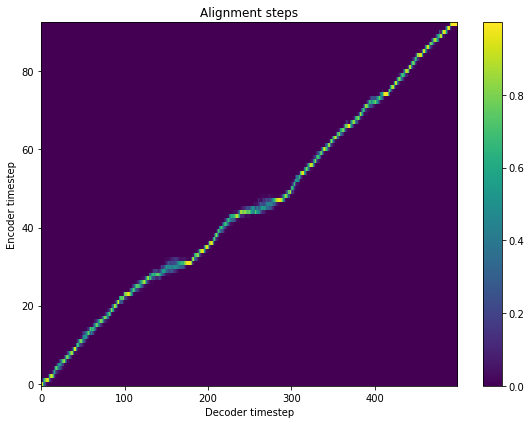

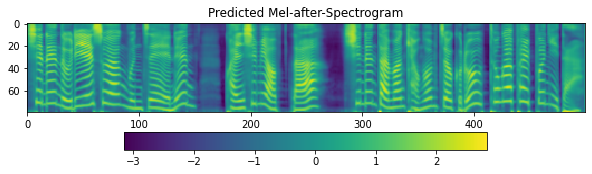

In [11]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

### (b) FastSpeech2 + MB-MELGAN

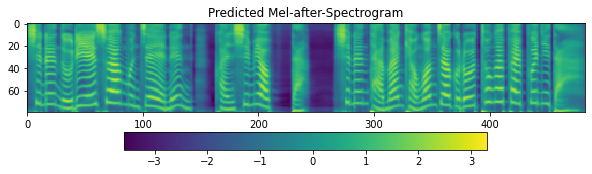

In [12]:
mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)